In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from scipy.stats import skew, boxcox
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline

In this project, classification models are built for predicting the wine quality based on the provided physicochemical tests. 

## 1. Load data

Red wine data is available in http://archive.ics.uci.edu/ml/datasets/Wine+Quality. There are 1599 samples in the dataset. Input variables (based on physicochemical tests) are: 1 - fixed acidity, 2 - volatile acidity, 3 - citric acid, 4 - residual sugar, 5 - chlorides, 6 - free sulfur dioxide, 7 - total sulfur dioxide, 8 - density, 9 - pH, 10 - sulphates, 11 - alcohol; Output variable (based on sensory data) is: 12 - quality (score between 0 and 10). There are no NaN in the dataset.

In [201]:
df_red = pd.read_csv('winequality-red.csv', sep=';')

In [202]:
df_red.shape

(1599, 12)

In [203]:
df_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [204]:
df_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 2. Data exploration analysis

In [205]:
feat = df_red.columns
col = feat.drop('quality')

### 2.1 Relationships between features

High correlations (>0.6) appear in between these pairs: fixed acidity and citric acid, fixed acidity and density, fixed acidity and PH, total sulfur dioxide and free sulfur dioxide. 

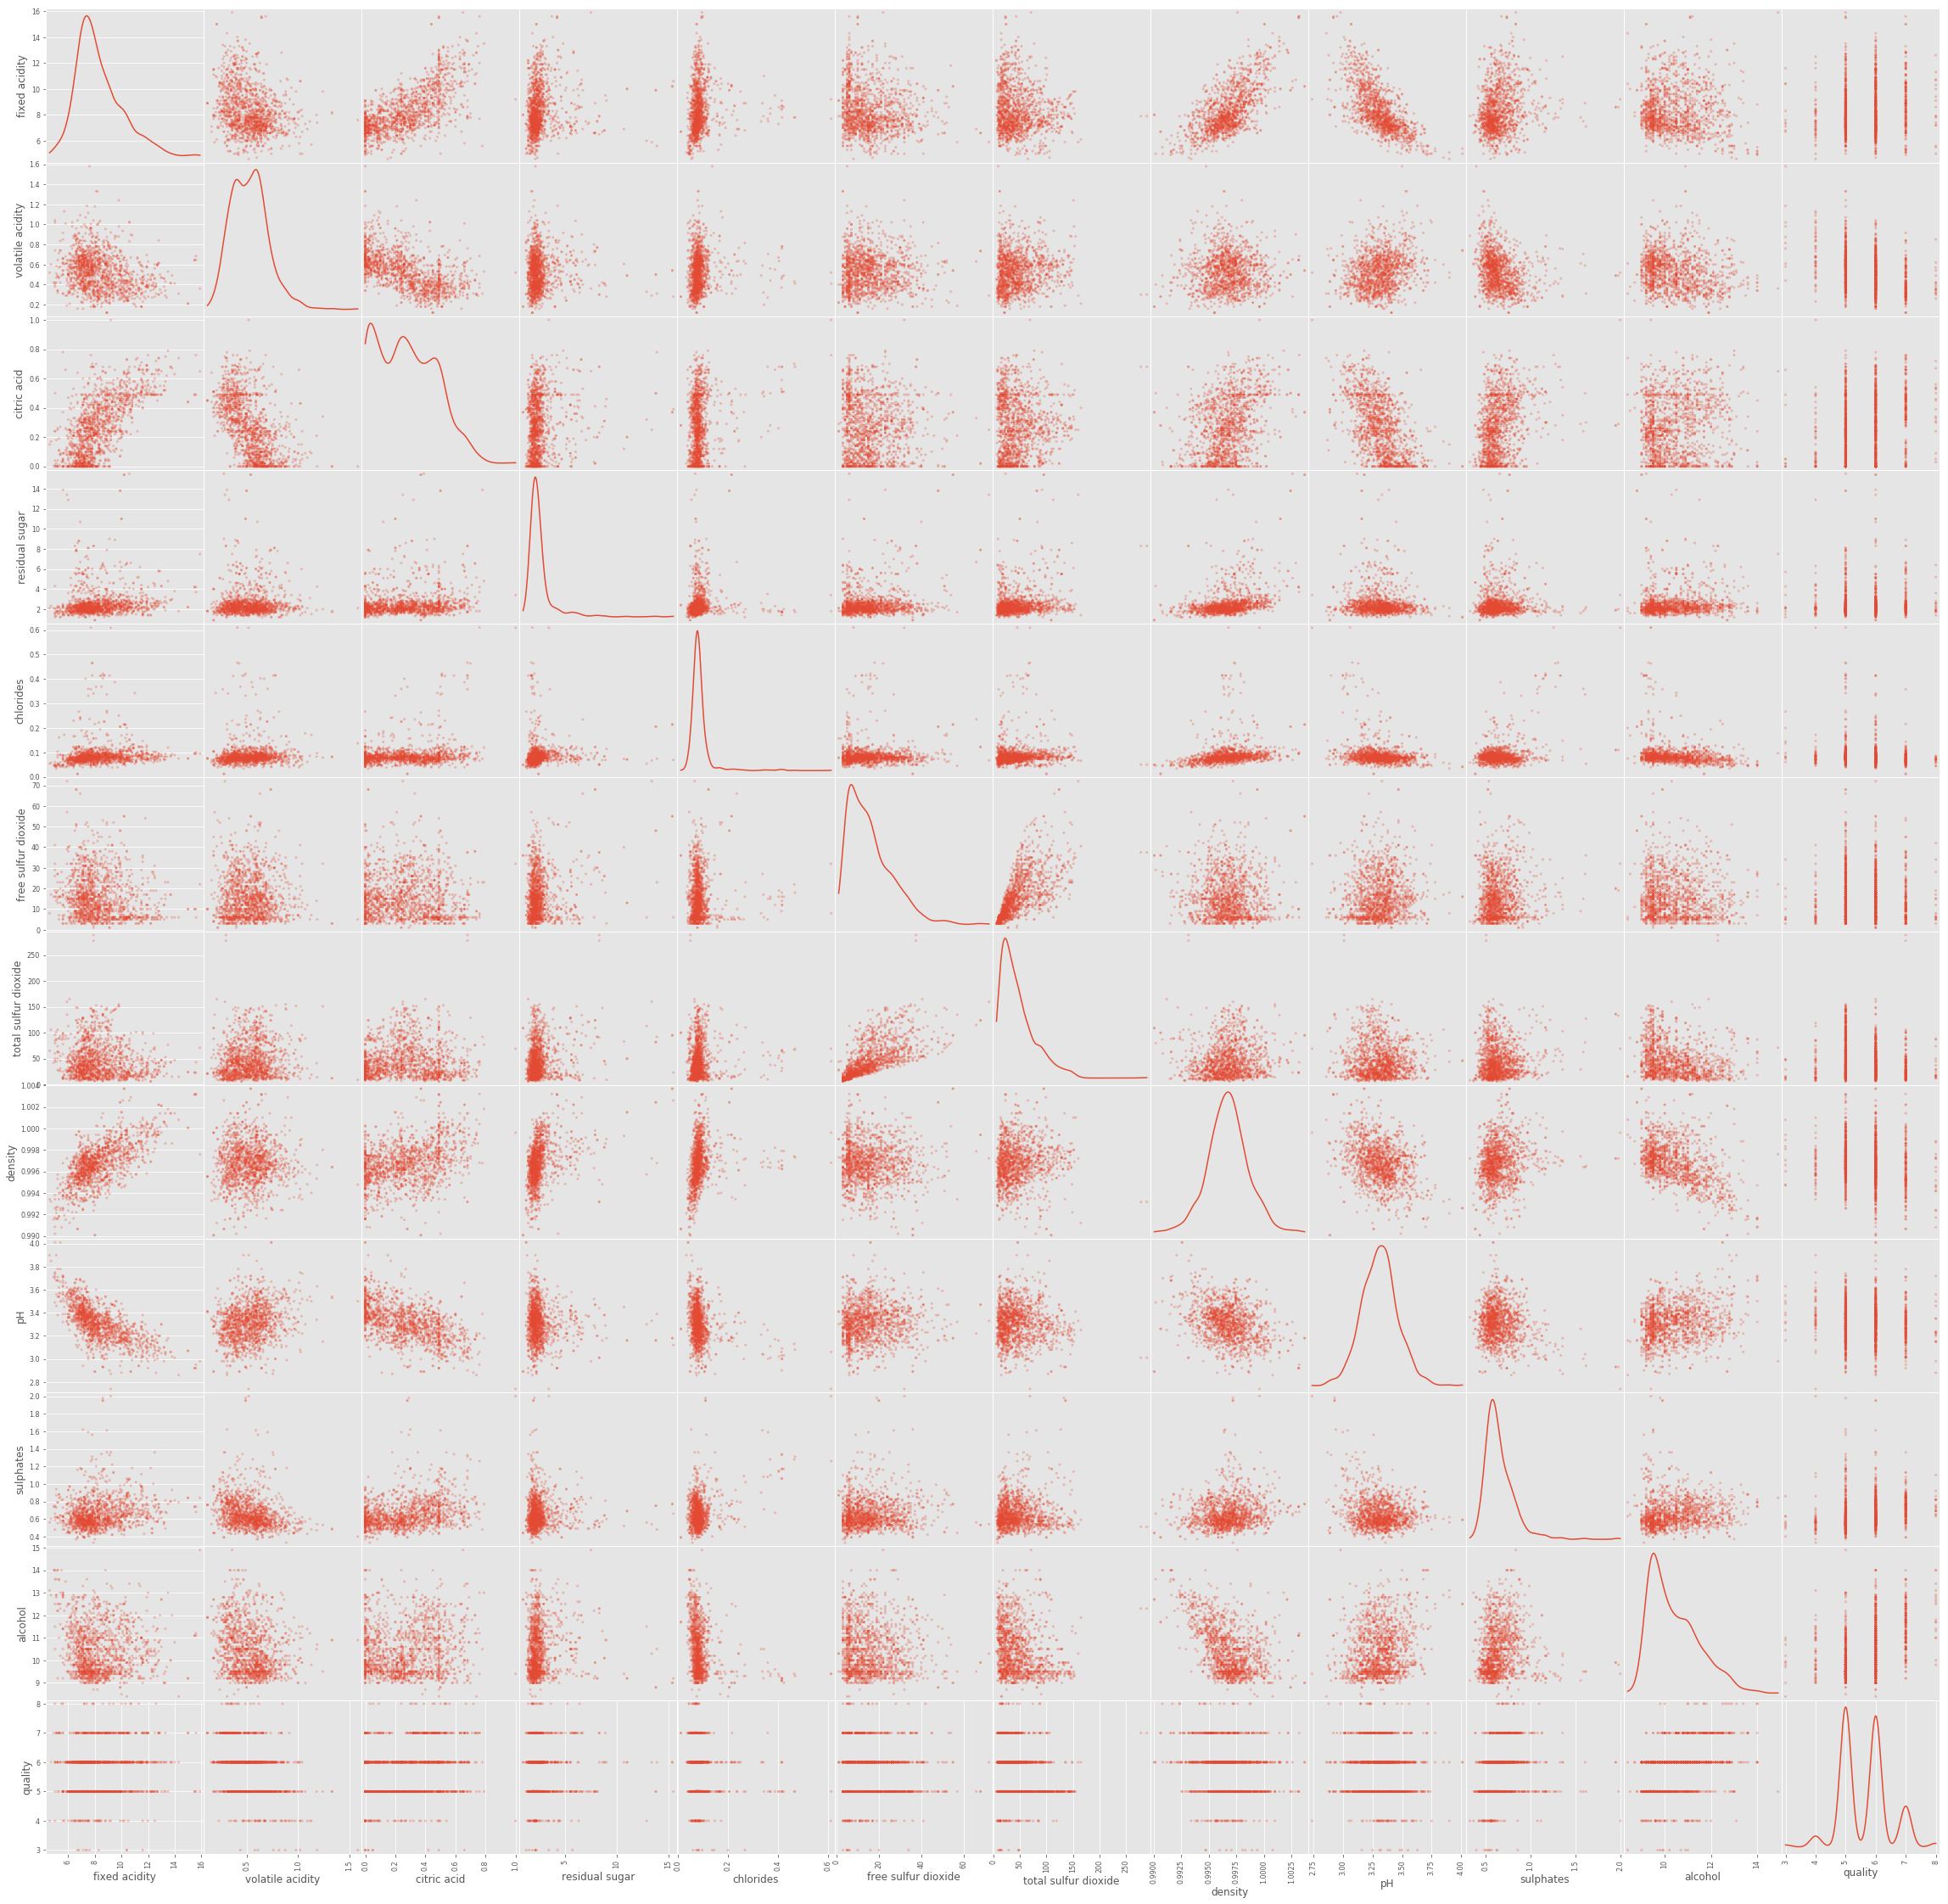

In [206]:
pd.plotting.scatter_matrix(df_red, alpha = 0.3, figsize = (40,40), diagonal = 'kde');

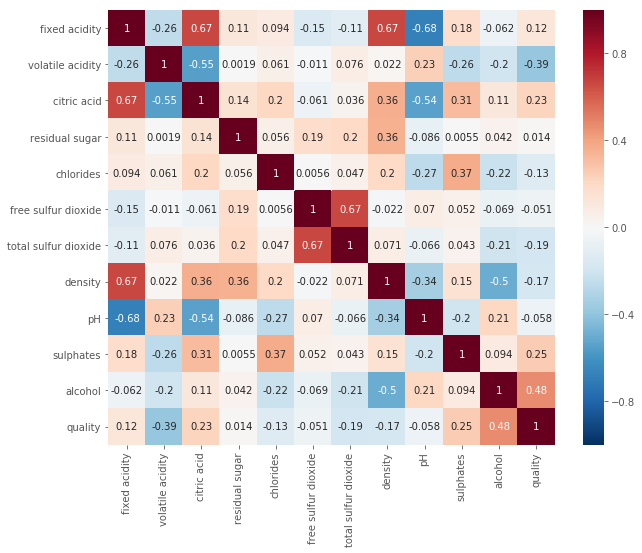

In [207]:
correlation = df_red.corr()
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

### 2.2 Outliers

Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we use Tukey's Method for identfying outliers: An outlier step is calculated as 2 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below:<br>
Assign the value of the 25th percentile for the given feature to Q1. Use np.percentile for this.<br>
Assign the value of the 75th percentile for the given feature to Q3. Again, use np.percentile.<br>
Assign the calculation of an outlier step for the given feature to step.<br>
Optional: remove data points from the dataset by adding indices to the outliers list.

In [208]:
# For each feature find the data points with extreme high or low values
outliers  = []

for feature in df_red.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(df_red[feature], q=25)
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(df_red[feature], q=75)
    # Use the interquartile range to calculate an outlier step (2 times the interquartile range)
    interquartile_range = Q3 - Q1
    step = 2 * interquartile_range
    
    # Display the outliers
    #print("Data points considered outliers for the feature '{}':".format(feature))
    #display(df_red[~((df_red[feature] >= Q1 - step) & (df_red[feature] <= Q3 + step))])
    idx = df_red[~((df_red[feature] >= Q1 - step) & (df_red[feature] <= Q3 + step))].index.values
    outliers.extend(idx)
    #print("# of outliers for the feature '{}':".format(feature))
    #display(df_red[~((df_red[feature] >= Q1 - step) & (df_red[feature] <= Q3 + step))].index.values.size)
outliers = np.unique(outliers)
outliers.size

259

In [209]:
# Remove the outliers, if any were specified
df = df_red.drop(outliers).reset_index(drop = True)
df.shape

(1340, 12)

### 2.3 Distribution of features

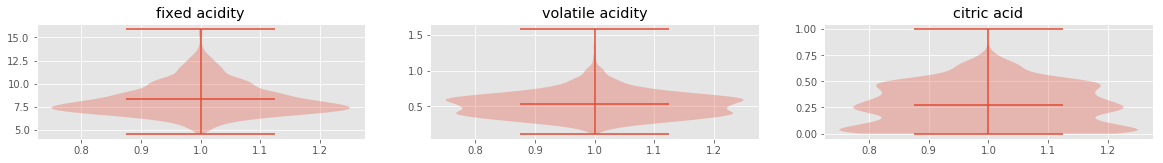

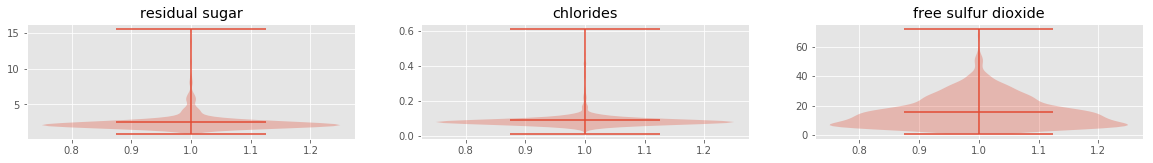

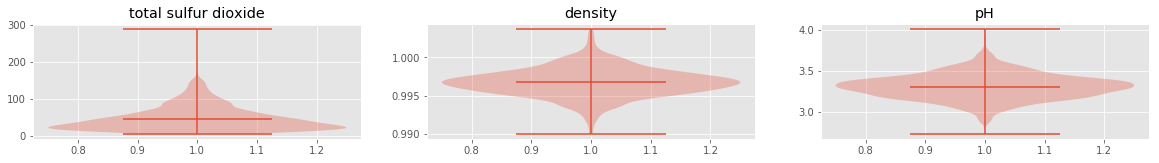

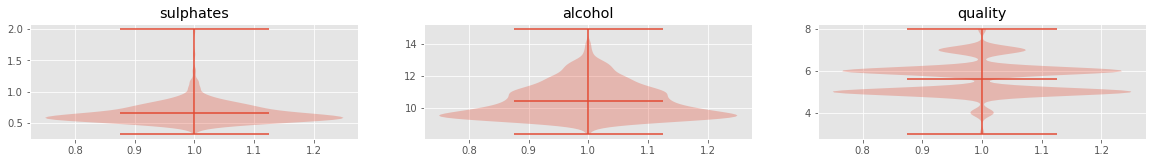

In [210]:
count=1
for i in range(0,len(feat),3):
    fig = plt.figure(figsize=(20,30))
    plt.subplot(len(feat),3,count)
    plt.violinplot(df_red[feat[i]],showmeans=True)
    plt.title(feat[i])
    
    plt.subplot(len(feat),3,count+1)
    plt.violinplot(df_red[feat[i+1]],showmeans=True)
    plt.title(feat[i+1])
    
    plt.subplot(len(feat),3,count+2)
    plt.violinplot(df_red[feat[i+2]],showmeans=True)
    plt.title(feat[i+2])
    count+=3

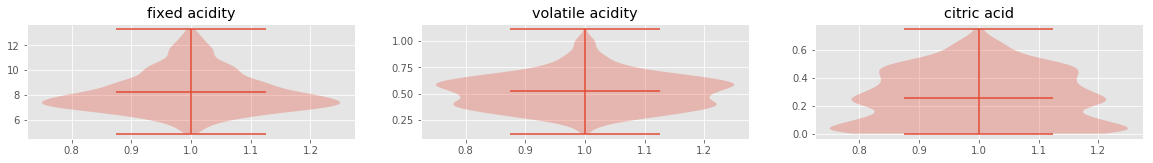

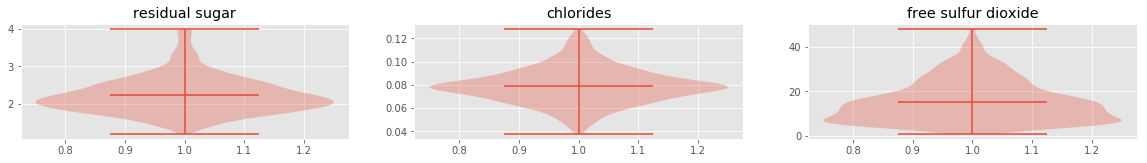

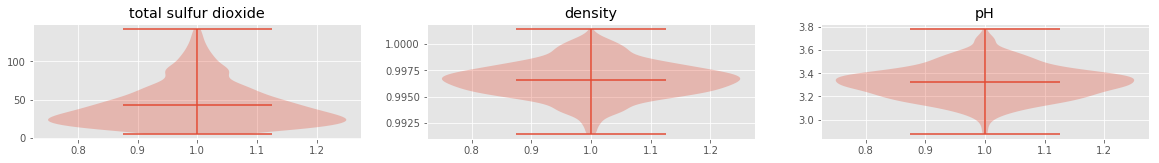

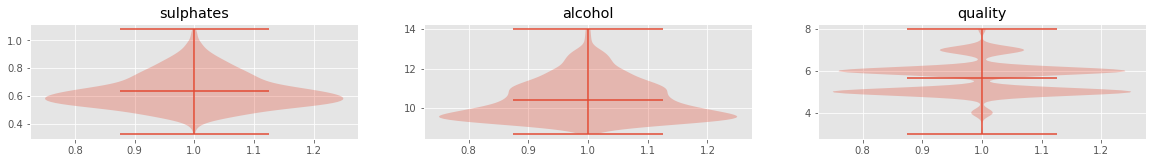

In [211]:
count=1
for i in range(0,len(feat),3):
    fig = plt.figure(figsize=(20,30))
    plt.subplot(len(feat),3,count)
    plt.violinplot(df[feat[i]],showmeans=True)
    plt.title(feat[i])
    
    plt.subplot(len(feat),3,count+1)
    plt.violinplot(df[feat[i+1]],showmeans=True)
    plt.title(feat[i+1])
    
    plt.subplot(len(feat),3,count+2)
    plt.violinplot(df[feat[i+2]],showmeans=True)
    plt.title(feat[i+2])
    count+=3

The distribution before and after removing outliers are shown as above. The outliers are removed as expected. 

Data is also sknewd. Apply box-cox transformation to imporve the skewness.

In [212]:
skewed_cols = df_red[col].apply(lambda x: skew(x.dropna()))
print (skewed_cols)

fixed acidity           0.981829
volatile acidity        0.670962
citric acid             0.318039
residual sugar          4.536395
chlorides               5.675017
free sulfur dioxide     1.249394
total sulfur dioxide    1.514109
density                 0.071221
pH                      0.193502
sulphates               2.426393
alcohol                 0.860021
dtype: float64


In [213]:
skewed_cols = skewed_cols[abs(skewed_cols) > 0.25].index.values
for skewed_col in skewed_cols:
    df_red[skewed_col], lam = boxcox(df_red[skewed_col_r] + 1)

In [214]:
skewed_cols = df_red[col].apply(lambda x: skew(x.dropna()))
print (skewed_cols)

fixed acidity           0.112266
volatile acidity        0.112266
citric acid             0.112266
residual sugar          0.112266
chlorides               0.112266
free sulfur dioxide     0.112266
total sulfur dioxide    0.112266
density                 0.071221
pH                      0.193502
sulphates               0.112266
alcohol                 0.112266
dtype: float64


Standard scaler method is applied to scale all the features to the same range. The violin plot shows that the ranges are changed as expected. 

In [215]:
SSL = preprocessing.StandardScaler()
for scol in col:
     df_red[scol] = SSL.fit_transform(df_red[scol].values.reshape(-1,1))

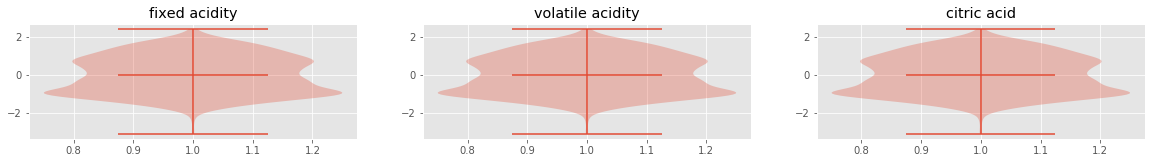

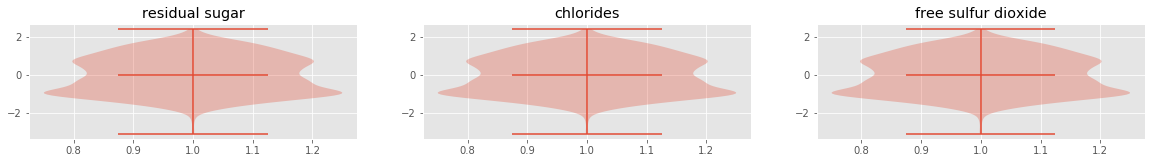

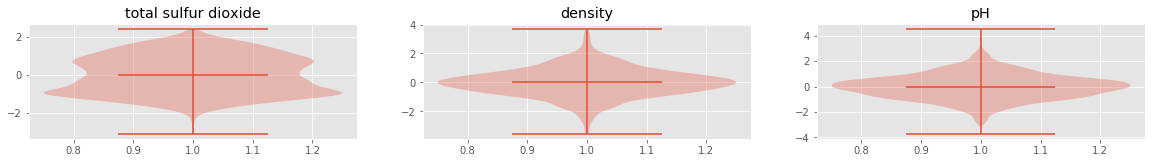

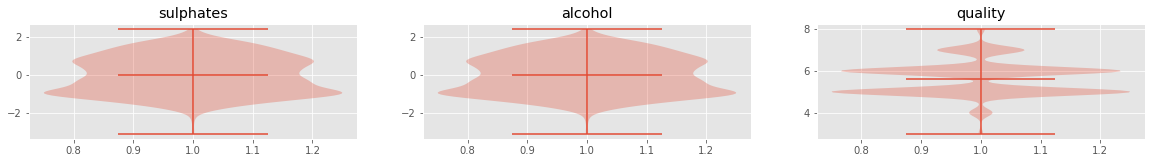

In [216]:
count=1
for i in range(0,len(feat),3):
    fig = plt.figure(figsize=(20,30))
    plt.subplot(len(feat),3,count)
    plt.violinplot(df_red[feat[i]],showmeans=True)
    plt.title(feat[i])
    
    plt.subplot(len(feat),3,count+1)
    plt.violinplot(df_red[feat[i+1]],showmeans=True)
    plt.title(feat[i+1])
    
    plt.subplot(len(feat),3,count+2)
    plt.violinplot(df_red[feat[i+2]],showmeans=True)
    plt.title(feat[i+2])
    count+=3

### 2.3 Label (quality) distribution

<function matplotlib.pyplot.show>

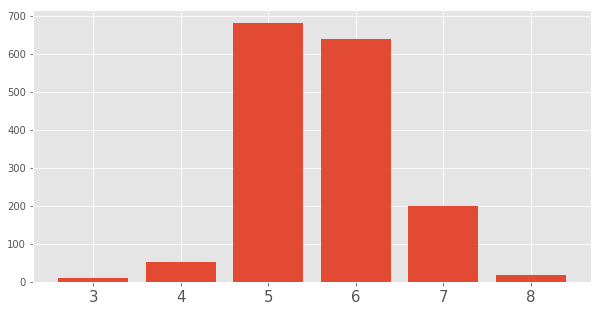

In [217]:
fig = plt.figure(figsize=(10,5))
plt.bar(df_red['quality'].value_counts().index, df_red['quality'].value_counts().values)
plt.xticks(df_red['quality'].value_counts().index, fontsize=15)
plt.show

Data is highly umbalanced, which requires specal treatment.

In [218]:
df_red['quality'].value_counts()/df_red.shape[0]

5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64

### 2.4 Data splitting

In [219]:
Y = df_red['quality']
X = df_red.drop(['quality'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)

In [220]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1279, 11)
(1279,)
(320, 11)
(320,)


## 3. Models

**Logistic regression**

In [221]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)

In [222]:
print(classification_report(y_test, lr_pred))
print('Accuracy score:', accuracy_score(y_test, lr_pred))

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         2
          4       0.00      0.00      0.00         8
          5       0.62      0.74      0.68       138
          6       0.58      0.37      0.45       131
          7       0.41      0.51      0.45        39
          8       0.00      0.00      0.00         2

avg / total       0.55      0.53      0.53       320

Accuracy score: 0.53125


**Decision Tree**

In [223]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=3, class_weight='balanced')
dt.fit(x_train,y_train)
dt_pred = dt.predict(x_test)

In [224]:
print(classification_report(y_test, dt_pred))
print('Accuracy score:', accuracy_score(y_test, dt_pred))

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         2
          4       0.03      0.12      0.05         8
          5       0.62      0.57      0.59       138
          6       0.45      0.30      0.36       131
          7       0.39      0.62      0.48        39
          8       0.00      0.00      0.00         2

avg / total       0.50      0.45      0.46       320

Accuracy score: 0.446875


**Random Forest**

In [225]:
rf = RandomForestClassifier(n_estimators=50, class_weight='balanced')
rf.fit(x_train, y_train)
rf_pred=rf.predict(x_test)

In [226]:
print(classification_report(y_test, rf_pred))
print('Accuracy score:', accuracy_score(y_test, rf_pred))

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         2
          4       0.00      0.00      0.00         8
          5       0.66      0.70      0.68       138
          6       0.62      0.63      0.62       131
          7       0.54      0.49      0.51        39
          8       0.00      0.00      0.00         2

avg / total       0.60      0.62      0.61       320

Accuracy score: 0.61875


**SVM**

In [227]:
svc = SVC()
svc.fit(x_train, y_train)
svc_pred = svc.predict(x_test)

In [228]:
print(classification_report(y_test, svc_pred))
print('Accuracy score:', accuracy_score(y_test, svc_pred))

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         2
          4       0.00      0.00      0.00         8
          5       0.63      0.77      0.69       138
          6       0.54      0.62      0.57       131
          7       0.00      0.00      0.00        39
          8       0.00      0.00      0.00         2

avg / total       0.49      0.58      0.53       320

Accuracy score: 0.584375


In [229]:
param = {
    'C': [0.1,0.8,0.9,1,1.1,1.2,1.3,1.4],
    'kernel':['linear', 'rbf'],
    'gamma' :[0.1,0.8,0.9,1,1.1,1.2,1.3,1.4]
}
grid_svc = GridSearchCV(svc, param_grid=param, scoring='accuracy', cv=10)
grid_svc.fit(x_train, y_train)
grid_svc.best_params_

{'C': 1.4, 'gamma': 1.3, 'kernel': 'rbf'}

In [230]:
svc2 = SVC(C=1.4, gamma=1.4,kernel='rbf')
svc2.fit(x_train, y_train)
svc2_pred = svc2.predict(x_test)

In [231]:
print(classification_report(y_test, svc2_pred))
print('Accuracy score:', accuracy_score(y_test, svc2_pred))

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         2
          4       0.00      0.00      0.00         8
          5       0.63      0.74      0.68       138
          6       0.55      0.58      0.57       131
          7       0.47      0.23      0.31        39
          8       0.00      0.00      0.00         2

avg / total       0.55      0.58      0.56       320

Accuracy score: 0.584375


**KNN**

In [232]:
knn = KNeighborsClassifier(n_neighbors=y_train.value_counts().shape[0], weights='distance')
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)

In [233]:
print(classification_report(y_test, knn_pred))
print('Accuracy score:', accuracy_score(y_test, knn_pred))

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         2
          4       0.00      0.00      0.00         8
          5       0.66      0.72      0.69       138
          6       0.60      0.60      0.60       131
          7       0.56      0.49      0.52        39
          8       0.00      0.00      0.00         2

avg / total       0.60      0.62      0.61       320

Accuracy score: 0.615625


**XGBoost**

In [234]:
xgbc = xgb.XGBClassifier(seed=1234, 
                       learning_rate=0.01, 
                       n_estimators=1000,
                       max_depth=9,
                      )
xgbc.fit(x_train, y_train)
xgbc_pred = xgbc.predict(x_test)
xgbc_pred = np.rint(xgbc_pred)

In [235]:
print(classification_report(y_test, xgbc_pred))
print('Accuracy score:', accuracy_score(y_test, xgbc_pred))

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         2
          4       0.00      0.00      0.00         8
          5       0.67      0.69      0.68       138
          6       0.59      0.66      0.62       131
          7       0.65      0.44      0.52        39
          8       0.00      0.00      0.00         2

avg / total       0.61      0.62      0.61       320

Accuracy score: 0.61875


## 4. Ensemble model

In [236]:
eclf = VotingClassifier(estimators=[('Random_Forest',rf), ('KNN', knn),('XGBoost', xgbc), ('SVM', svc2) ], voting='hard')

In [237]:
eclf.fit(x_train,y_train)
eclf_pred = eclf.predict(x_test)

In [238]:
print(classification_report(y_test, eclf_pred))
print('Accuracy score:', accuracy_score(y_test, eclf_pred))

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         2
          4       0.00      0.00      0.00         8
          5       0.65      0.75      0.70       138
          6       0.63      0.64      0.63       131
          7       0.62      0.38      0.48        39
          8       0.00      0.00      0.00         2

avg / total       0.61      0.63      0.62       320

Accuracy score: 0.634375


** Save model**

In [239]:
import pickle
pickle.dump(eclf, open('eclf.pkl', "wb"))
with open('eclf.pkl', 'wb') as outfile:
    pickle.dump(eclf, outfile)